In [66]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from mst_prim import prim_mst
from nemo import evaluate_nemo
import util
from util import lighten_color
from util import centroid_label, coordinator_label, worker_label, ccolor, cmarker
from topology import get_lognorm_hist, setup_topology, get_lognorm_samples, add_cluster_labels
import topology

plt.rcParams.update({'font.size': 12})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Topology Setup

In [97]:
seed = 4
np.random.seed(seed)

device_number = 1000 + 1
avg = 20
c_capacity = 50
max_resources = device_number * avg - 100

X_dim_range = [0, 100]
Y_dim_range = [-50, 50]
centers = 40

H, bins = get_lognorm_hist()
coords_df = topology.coords_sim(1000, centers, X_dim_range, Y_dim_range, seed)

coord_dict = topology.get_coords_dict()
coord_dict["sim_1000"] = coords_df
df_dict_topologies = topology.create_topologies_from_dict(coord_dict, H, max_resources, c_capacity,
                                                          weights=(1, avg * 2), dist="lognorm", with_clustering=True,
                                                          kmin=2, kmax=30, kseed=10)

Creating df for planetlab
Optimal k is 3
Creating df for king
Optimal k is 6
Creating df for fit
Optimal k is 3
Creating df for sim_1000
Optimal k is 21
Done


In [104]:
t_label = "sim_1000"
prim_df, c_coords, base_col, slot_columns, centroids, opt_k, sil = df_dict_topologies[t_label]
coords = prim_df[["x", "y"]].to_numpy()

eval_matrix = {}
prim_df

,x,y,latency,type,base,weight,capacity_100,capacity_90,capacity_80,capacity_70,capacity_60,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1,cluster
0,19.383905,7.406120,0.000000,coordinator,9223372036854775807,0,50,50,50,50,50,50,50,50,50,50,50,50,-1
1,67.743232,-14.007158,52.888118,worker,9223372036854775807,14,20,21,19,19,22,18,22,18,12,8,28,0,3
2,5.220579,-15.467092,26.903228,worker,9223372036854775807,1,20,22,21,20,24,21,16,20,11,9,7,26,8
3,43.521014,41.129903,41.471599,worker,9223372036854775807,1,20,22,23,18,19,23,25,32,11,12,65,19,14
4,14.195029,1.412734,7.927491,worker,9223372036854775807,1,20,22,19,17,17,23,28,35,13,37,14,3,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,14.908514,-3.352142,11.652010,worker,9223372036854775807,1,20,21,19,23,20,28,23,26,15,9,22,104,19
997,39.672067,34.499402,33.847532,worker,9223372036854775807,3,20,22,21,22,19,18,17,27,11,11,5,13,14
998,40.609309,23.985392,26.933066,worker,9223372036854775807,1,20,21,22,18,20,15,32,17,48,9,10,2,6
999,31.878351,34.859971,30.163307,worker,9223372036854775807,2,20,21,20,19,24,15,25,34,10,14,16,56,2


In [105]:
print("Required:", prim_df["weight"].sum(), "Available:", prim_df["capacity_100"].sum())

Required: 5918 Available: 20050


In [106]:
colors, light_colors, palette = util.get_color_list(opt_k)
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)]

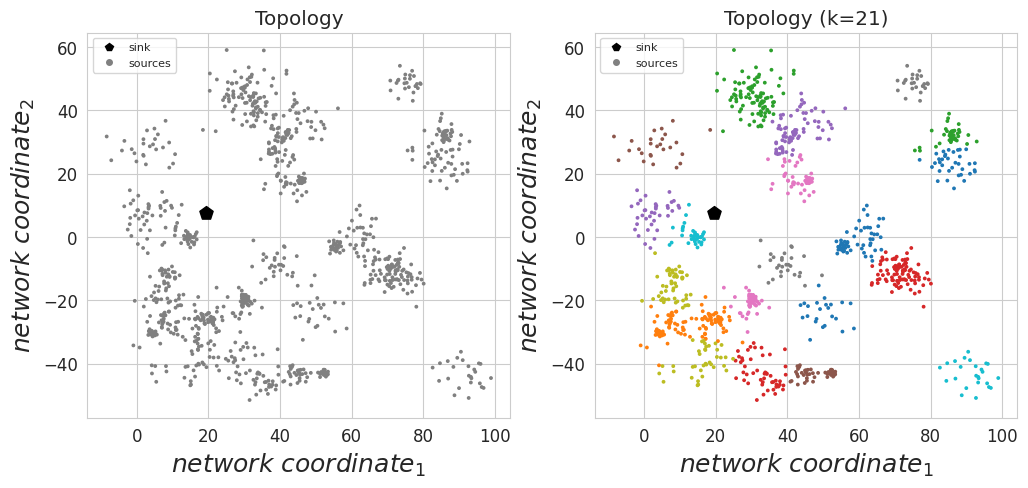

In [108]:
X_dim_def = [-50, 50]
Y_dim_def = [-60, 60]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
util.plot_topology(ax1, prim_df)
util.plot_topology(ax2, prim_df, colors, 'Topology (k=' + str(opt_k) + ")")

#ax1.set_xlim(X_dim_def)
#ax2.set_xlim(X_dim_def)

#ax1.set_ylim(Y_dim_def)
#ax2.set_ylim(Y_dim_def)

X_dim = ax1.get_xlim()
Y_dim = ax1.get_ylim()

plt.show()

### Experiment 2b: NEMO Aggregation with Density-based Grouping

In [8]:
# assign nodes to previous clustering alg
iterations = 10
max_levels = 50

slot_col = "capacity_100"
eval_name = "nemo"
weight_col = "weight"

eval_ig, df_dict_opt, opt_dict_opt = evaluate_nemo(prim_df, coords, centroids, [slot_col], iterations=iterations,
                                                   max_levels=1,
                                                   weight_col=weight_col, weighting="spring")
eval_matrix[eval_name], df_dict, opt_dict = evaluate_nemo(prim_df, coords, centroids, ["base", slot_col],
                                                          iterations=iterations,
                                                          weight_col=weight_col, weighting="spring", max_levels=50,
                                                          show_eval=True)

Starting nemo for capacity_100 with spring and weight and level: 1
Evaluating for capacity_100
Starting nemo for base with spring and weight and level: 50
Evaluating for base
Starting nemo for capacity_100 with spring and weight and level: 50
Evaluating for capacity_100


In [9]:
df = df_dict[slot_col]
df

,oindex,x,y,type,cluster,total_weight,used_weight,total_capacity,free_capacity,level,parent,latency,load
0,0,19.383905,7.406120,coordinator,-1,0,0,50,37,6,0,0.000000,13
1,1,67.743232,-14.007158,worker,8,1,1,20,20,0,194,73.553715,0
2,2,5.220579,-15.467092,worker,1,1,1,20,20,0,802,83.502040,0
3,3,43.521014,41.129903,worker,2,5,5,20,20,0,123,72.194386,0
4,4,14.195029,1.412734,worker,6,2,2,20,11,1,382,59.267675,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223,998,40.609309,23.985392,worker,11,33,20,20,16,1,699,56.145529,4
1224,998,40.609309,23.985392,worker,11,33,8,20,16,1,836,56.145529,4
1225,999,31.878351,34.859971,worker,2,4,4,20,2,1,538,46.164762,18
1226,1000,44.528343,34.090418,worker,11,18,13,20,20,0,133,76.324795,0


In [10]:
df[df["parent"] == df["oindex"]]

,oindex,x,y,type,cluster,total_weight,used_weight,total_capacity,free_capacity,level,parent,latency,load
0,0,19.383905,7.40612,coordinator,-1,0,0,50,37,6,0,0.0,13


In [11]:
df[df["parent"] == 0]

,oindex,x,y,type,cluster,total_weight,used_weight,total_capacity,free_capacity,level,parent,latency,load
0,0,19.383905,7.406120,coordinator,-1,0,0,50,37,6,0,0.000000,13
83,71,32.543847,-1.122257,worker,3,3,3,20,2,5,0,15.681750,18
244,200,47.344478,14.203998,worker,11,1,1,20,11,5,0,28.775072,9
357,285,40.477777,29.838068,worker,11,1,1,20,15,5,0,30.791942,5
562,455,8.837530,-10.335794,worker,6,2,2,20,12,5,0,20.639805,8
688,552,89.378390,17.684328,worker,4,1,1,20,0,5,0,70.745102,20
753,607,88.166979,25.359715,worker,4,2,2,20,13,5,0,71.087571,7
849,682,38.471182,-7.296501,worker,3,1,1,20,11,5,0,24.093385,9
1191,974,46.558442,17.438151,worker,11,1,1,20,18,5,0,28.967172,2
1210,989,88.869413,21.381167,worker,4,1,1,20,1,5,0,70.876919,19


In [12]:
# check -> should be empty
df_overloaded = df.groupby(['parent'])['used_weight'].sum().copy().reset_index()
df_join = df[["oindex", "total_capacity", "free_capacity"]]
result = pd.merge(df_join, df_overloaded, left_on='oindex', right_on='parent', how='inner')
result["delta"] = result["total_capacity"] - result["used_weight"]
result[result["delta"] < 0]

,oindex,total_capacity,free_capacity,parent,used_weight,delta


In [13]:
# check -> should be empty
result[result["delta"] != result["free_capacity"]]

,oindex,total_capacity,free_capacity,parent,used_weight,delta


In [14]:
result

,oindex,total_capacity,free_capacity,parent,used_weight,delta
0,0,50,37,0,13,37
1,4,20,11,4,9,11
2,5,20,13,5,7,13
3,6,20,0,6,20,0
4,7,20,5,7,15,5
...,...,...,...,...,...,...
473,996,20,18,996,2,18
474,998,20,16,998,4,16
475,998,20,16,998,4,16
476,998,20,16,998,4,16


In [15]:
#create greedy aggregation tree
cluster_coords = centroids
cluster_coords_with_crd = np.column_stack((c_coords, cluster_coords.T)).T

mst = prim_mst(cluster_coords_with_crd)

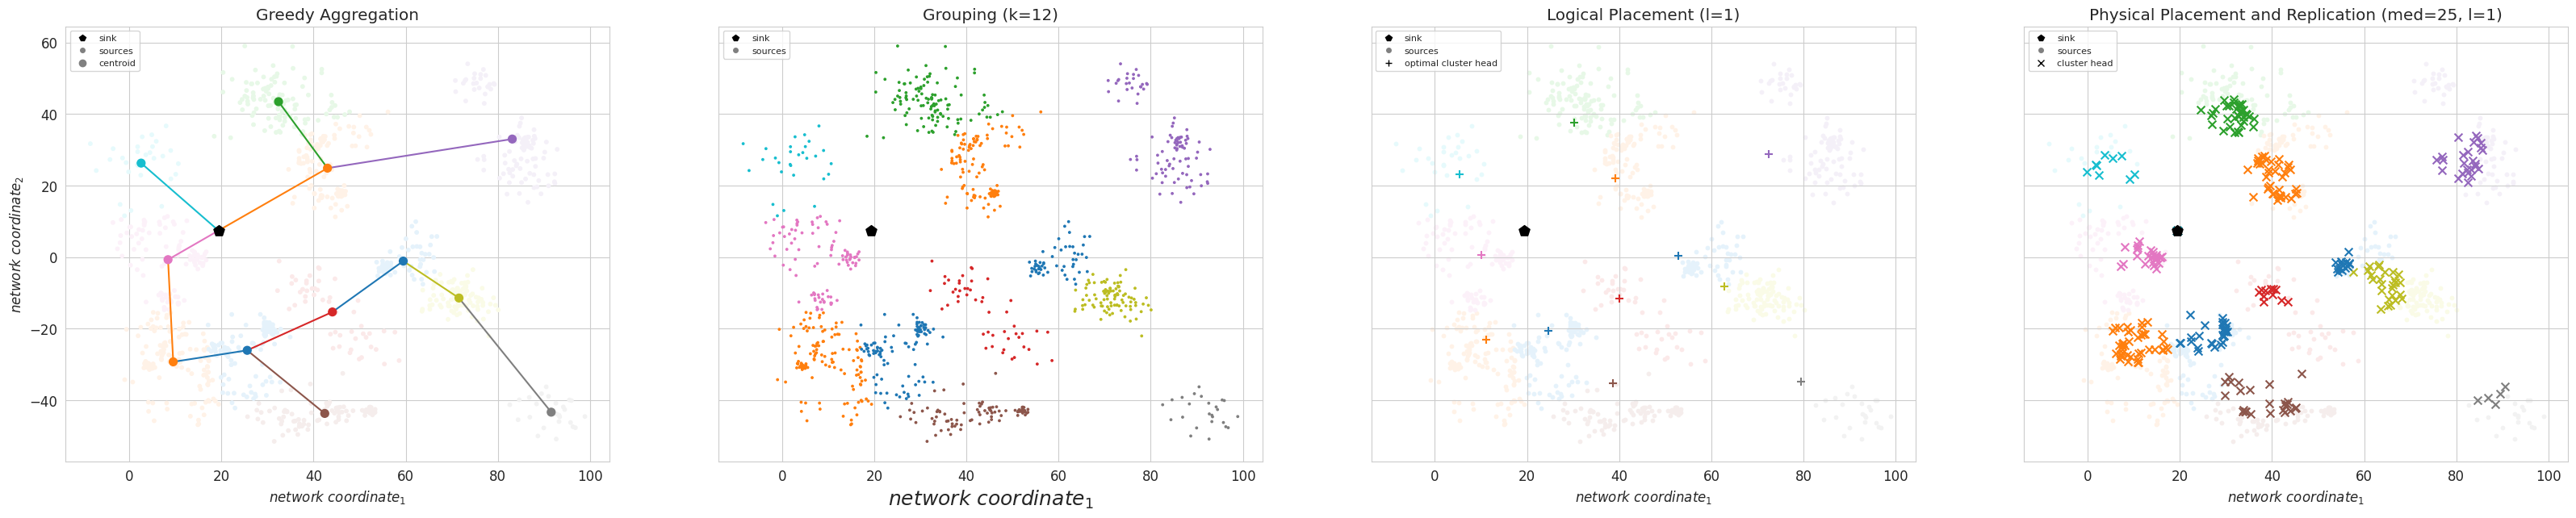

In [16]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")
lval = 0.1
labels = prim_df["cluster"]

# plot greedy approach from MST
for i in range(1, len(mst)):
    point1 = cluster_coords_with_crd[i]
    point2 = cluster_coords_with_crd[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    ax1.plot(x_values, y_values, zorder=2, color=colors[i - 1])

ax1.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=10)
ax1.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:len(cluster_coords)], zorder=3)
# in case all coords shall be plotted
ax1.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, lval) for x in colors[labels]])

lcentroid = Line2D([], [], color="blue", marker='o', linestyle='None', label='centroid')
ax1.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1),
           fontsize=8)

ax1.set_xlabel('$network$ $coordinate_1$')
ax1.set_ylabel('$network$ $coordinate_2$')
ax1.set_title('Greedy Aggregation')

#plot grouping
util.plot_topology(ax2, prim_df, colors, title='Grouping (k=' + str(opt_k) + ")")

#plot logical nodes (optima) of different groups
# util.plot2(ax3, prim_df, df_dict[slot_col], colors, lval=lval, show_centroids=True)
util.plot_optimum(ax3, prim_df, opt_dict[slot_col], colors, lval=lval, plot_centroid=False, plot_lines=False)

# plot physical nodes
util.plot(ax4, prim_df, df_dict_opt[slot_col], colors, lval=lval, plot_centroids=False, plot_lines=False)

#plt.xlim(X_dim)
#plt.ylim(Y_dim)
ax3.set_title("Logical Placement (l=1)")
ax4.set_title("Physical Placement and Replication (med=" + str(25) + ", l=1)")

plt.savefig("plots/sim_1000/nemo_phases.svg", bbox_inches="tight")
plt.show()

Starting nemo for base with spring and weight and level: 1
Starting nemo for capacity_100 with spring and weight and level: 1
Starting nemo for base with spring and weight and level: 2
Starting nemo for capacity_100 with spring and weight and level: 2
Starting nemo for base with spring and weight and level: 5
Starting nemo for capacity_100 with spring and weight and level: 5
Starting nemo for base with spring and weight and level: 20
Starting nemo for capacity_100 with spring and weight and level: 20


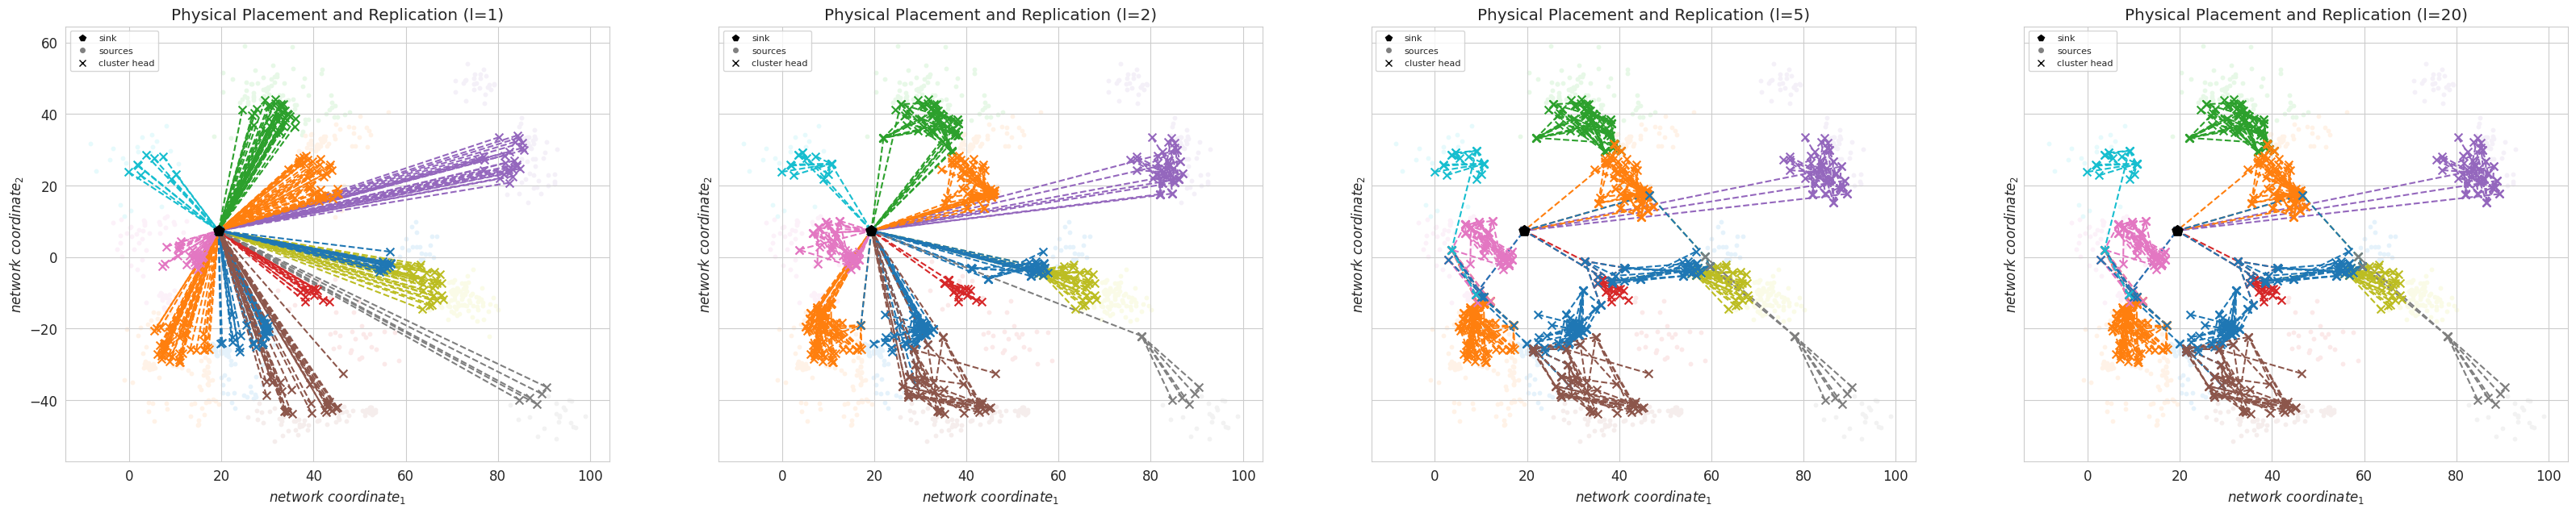

In [17]:
levels = [1, 2, 5, 20]
fig, axs = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")
lval = 0.1

for i, level in enumerate(levels):
    eval_ig, df_dict_i, opt_dict_i = evaluate_nemo(prim_df, coords, centroids, ["base", slot_col],
                                                   iterations=iterations,
                                                   weight_col=weight_col, weighting="spring", max_levels=level,
                                                   show_eval=False)
    util.plot(axs[i], prim_df, df_dict_i[slot_col], colors, lval=lval, plot_centroids=False, plot_lines=True)
    axs[i].set_title("Physical Placement and Replication (l=" + str(level) + ")")

plt.show()

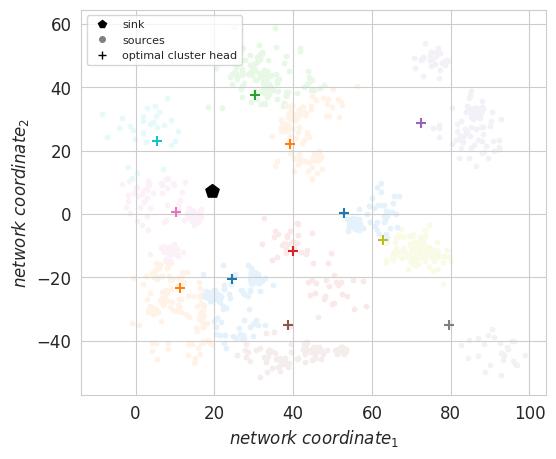

In [18]:
fig = plt.figure(figsize=(6, 5)).gca()

#uncomment this to plot nemo grouping
#ax2.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.2) for x in colors[labels]], zorder=-1)
#ax2.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:no_clusters], zorder=2)
#ax2.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=1)
#ax2.set_title('Grouping (k=' + str(opt_k) + ")")
#fig.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

#uncomment this for nemo placement
util.plot_optimum(fig, prim_df, opt_dict[slot_col], colors, lval=lval, plot_centroid=False, plot_lines=False)

#uncomment this for nemo redistribution
#util.plot(fig, new_paths_flat[slot_col], agg_dict_flat[slot_col], c_coords, cluster_coords, coords, colors, labels, changed_labels=reassigned_clussters, lval=lval)


fig.set_xlabel('$network$ $coordinate_1$')
fig.set_ylabel('$network$ $coordinate_2$')

#plt.savefig("plots/sim_1000/nemo_placement.svg", bbox_inches="tight")
plt.show()

## Evaluation

In [19]:
eval_matrix.keys()

dict_keys(['nemo'])

In [20]:
eval_matrix["nemo"].keys()

dict_keys(['base', 'capacity_100'])

In [21]:
eval_colors = {
    "nemo": colors[5],
    "nemo_base": "blue"
}

### Latency

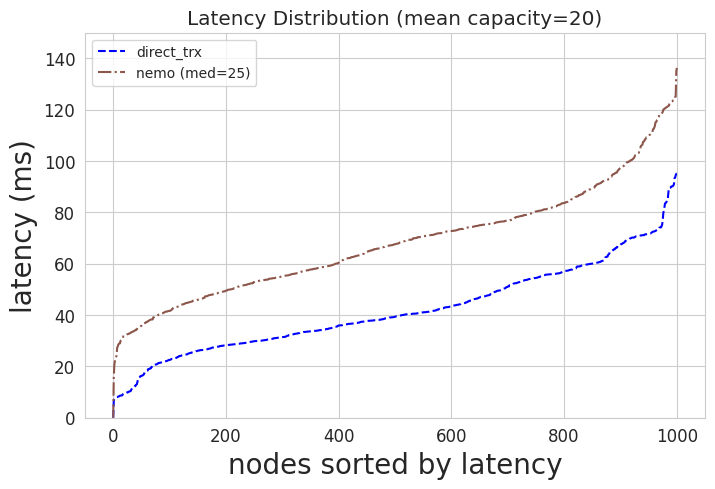

Means:  {'nemo (med=20)': 68.16}
Quantiles:  {'nemo (med=20)': 97.34}


In [22]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}
last_med_label = "25"

for l in eval_matrix.keys():
    emat = eval_matrix[l]

    i = 0
    for k, df in emat.items():
        #if i % 50 == 0:
        if l == "nemo" and k == "base":
            sv = df["latency_distribution"].sort_values()
            sv.plot(ax=ax1, use_index=False, label="direct_trx", color=eval_colors[l + "_base"], linestyle="--")
        elif k == "base":
            sv = df["latency_distribution"].sort_values()
            quant_dict[l] = round(sv.quantile(0.9), 2)
            mean_dict[l] = round(sv.mean(), 2)
            sv.plot(ax=ax1, use_index=False, label=l, color=eval_colors[l + "_base"], linestyle="--")
        elif k == "capacity_1":
            sv = df["latency_distribution"].sort_values()
            quant_dict[l + " (med=" + last_med_label + ")"] = round(sv.quantile(0.9), 2)
            mean_dict[l + " (med=" + last_med_label + ")"] = round(sv.mean(), 2)
            sv.plot(ax=ax1, use_index=False, label=l + " (med=" + last_med_label + ")", color=eval_colors[l],
                    linestyle="-.")
        elif k == "capacity_100":
            sv = df["latency_distribution"].sort_values()
            quant_dict[l + " (med=" + str(avg) + ")"] = round(sv.quantile(0.9), 2)
            mean_dict[l + " (med=" + str(avg) + ")"] = round(sv.mean(), 2)
            sv.plot(ax=ax1, use_index=False, label=l + " (med=" + last_med_label + ")", color=eval_colors[l],
                    linestyle="-.")
        i += 1

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')

ax1.legend(loc="upper left", prop={'size': 10})
# Display a figure.
plt.ylim([0, 150])

ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

plt.savefig("plots/sim_1000/eval_latency.svg")

ax1.set_title('Latency Distribution (mean capacity=' + str(avg) + ")")
plt.show()
print("Means: ", mean_dict)
print("Quantiles: ", quant_dict)

### Runtime

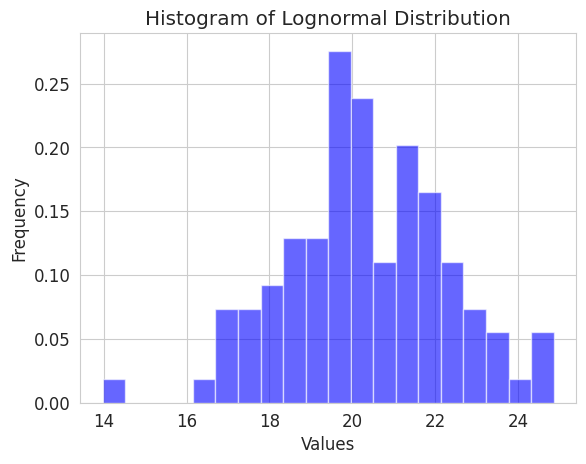

In [23]:
# Set the parameters
mean = 3.0  # Mean of the lognormal distribution
sigma = 0.1  # Standard deviation of the lognormal distribution
length = 100  # Desired length of the list

# Generate random values from a lognormal distribution
random_values = np.random.lognormal(mean, sigma, length)

# Plot a histogram of the random values
plt.hist(random_values, bins=20, density=True, alpha=0.6, color='b')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Lognormal Distribution')
plt.grid(True)

# Show the plot
plt.show()

In [154]:
start = 0.0
stop = 16
step = 0.25
values_topo = {}
slot_col = "capacity_100"

for t_label in df_dict_topologies.keys():
    print("Starting for topology", t_label)
    df, c_coords, base_col, slot_columns, centroids, opt_k, sil = df_dict_topologies[t_label]
    values = {}
    size = df.shape[0]
    current_mu = start
    while current_mu < stop:
        print(current_mu)
        out = get_lognorm_samples(1, avg * 2, size, mu=current_mu, sigma=1)
        df["weight"] = out
        na, df_dict, opt_dict, limits_dict = evaluate_nemo(df, centroids, [slot_col], iterations=10,
                                              weight_col="weight", weighting="spring", show_eval=False)
        if limits_dict[slot_col]:
            break
        
        levels = df_dict[slot_col].loc[0, "level"]
        cluster_heads = df_dict[slot_col]["parent"].nunique()
        ch_rel = cluster_heads / size
        values[current_mu] = (np.mean(out), np.median(out), np.max(out), levels, cluster_heads, ch_rel)
        current_mu += step

    values_topo[t_label] = values

print("Done")

Starting for topology planetlab
0.0
Starting nemo for capacity_100 with spring and weight and level: 20
0.25
Starting nemo for capacity_100 with spring and weight and level: 20
0.5
Starting nemo for capacity_100 with spring and weight and level: 20
0.75
Starting nemo for capacity_100 with spring and weight and level: 20
1.0
Starting nemo for capacity_100 with spring and weight and level: 20
1.25
Starting nemo for capacity_100 with spring and weight and level: 20
1.5
Starting nemo for capacity_100 with spring and weight and level: 20
1.75
Starting nemo for capacity_100 with spring and weight and level: 20
2.0
Starting nemo for capacity_100 with spring and weight and level: 20
2.25
Starting nemo for capacity_100 with spring and weight and level: 20
2.5
Starting nemo for capacity_100 with spring and weight and level: 20
2.75
Starting nemo for capacity_100 with spring and weight and level: 20
3.0
Starting nemo for capacity_100 with spring and weight and level: 20
Topology does not contain 

In [161]:
plot_topo = {
    "sim_1000": {"color": "blue", "marker": "s"},
    "fit": {"color": "purple", "marker": "D"},
    "planetlab": {"color": "gold", "marker": "v"},
    "king": {"color": "teal", "marker": "p"}
}

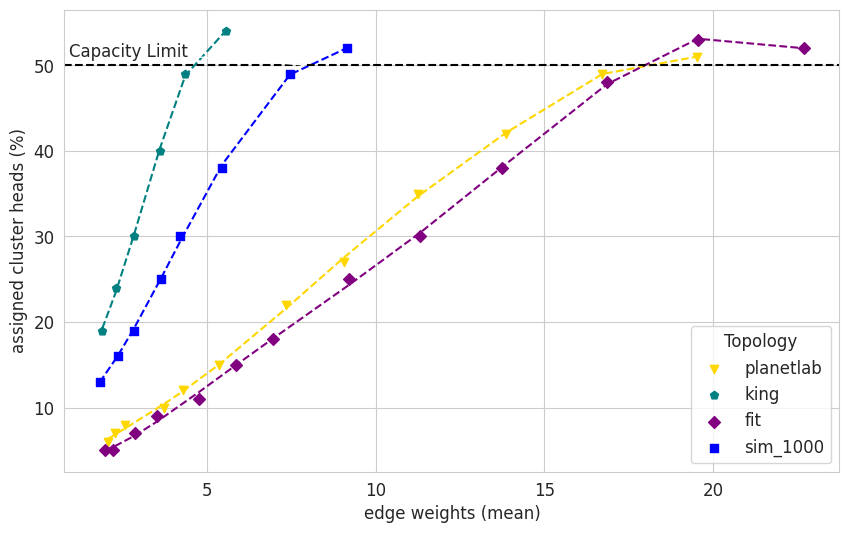

In [170]:
# Specify the figure size (e.g., 8x6 inches)
fig, ax = plt.subplots(figsize=(10, 6))

for k in values_topo.keys():
    data_dict = values_topo[k]
    
    # Extract the keys and values from the dictionary
    keys = list(data_dict.keys())
    x_values = [round(item[0], 2) for item in data_dict.values()]
    y_values = [round(item[5], 2) * 100 for item in data_dict.values()]
    
    c = plot_topo[k]["color"]
    m = plot_topo[k]["marker"]
    
    # Create the main plot
    ax.scatter(x_values, y_values, marker=m, color=c, label=k)
    
    # Calculate the regression line
    coefficients = np.polyfit(x_values, y_values, len(keys) / 2)
    regression_line = np.polyval(coefficients, x_values)
    
    # Plot the regression line
    ax.plot(x_values, regression_line, "--", color=c)

# Add the vertical dashed line at x=8
#vertical_line_x = 8.5
#ax.axvline(x=vertical_line_x, color='r', linestyle='--')

# Add an annotation at the vertical line
#annotation_x = 8.7
#annotation_y = 320
#ax.annotate('resource \nlimit', xy=(vertical_line_x, annotation_y), xytext=(annotation_x, annotation_y),
#            arrowprops=dict(arrowstyle='->'))

# Add the horizontal dashed line at y=320
horizontal_line_y = 50
ax.axhline(y=horizontal_line_y, color='black', linestyle='--')

# Add an annotation at the horizontal line
annotation_x = 0.9  # X-coordinate of the annotation
annotation_y = 51  # Y-coordinate of the annotation
ax.annotate('Capacity Limit', xy=(8, horizontal_line_y), xytext=(annotation_x, annotation_y),
            arrowprops=dict(arrowstyle='->'))

# Set axis labels and title for the main plot
ax.set_xlabel('edge weights (mean)')
ax.set_ylabel('assigned cluster heads (%)')

# Create a legend for the scatter plot with a label
legend = ax.legend()
legend.set_title("Topology")

# Display the plot
plt.show()